### IMPORT LIBRARIES

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from ydata_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
df1 = pd.read_csv("comments.csv", encoding="utf-8")

In [10]:
df1.head()

,product_id,comment_id,title,thank_count,customer_id,rating,comment
0,74021317,12559756,Cực kì hài lòng,313,22051463,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,74021317,16979365,Cực kì hài lòng,6,27791831,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,74021317,14069617,Cực kì hài lòng,25,17748750,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,74021317,8569824,Cực kì hài lòng,57,410797,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,74021317,18368714,Cực kì hài lòng,0,28545286,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


In [11]:
df1.shape

(141281, 7)

In [12]:
df1['rating'].value_counts()

5    114514
4     14295
3      5276
1      4495
2      2701
Name: rating, dtype: int64

# CLASSIFICATION 

### POSITIVE

In [13]:
df_notlike = df1[df1['rating'] < 3 ]

In [14]:
df_notlike.value_counts()

product_id  comment_id  title               thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                  
527316      5688526     Không hài lòng      0            18990092     2       sách dơ, góc bị nhăn . Khá là buồn                                                                                                                                                                                                                                                                                           6
53095307    6786178     Không hài lòng      0            370250       2       sách mình mới mua dc vài hôm.hôm nay mở ra xem thì đã bị như thế này rồi. thật sự khá thật vọng. mong tiki xem xét lại khâu quản lí t

In [19]:
df_notlike.shape

(7196, 7)

### NEUTRAL

In [15]:
df_neutral= df1[df1['rating'] == 3 ]

In [16]:
df_neutral.value_counts()

product_id  comment_id  title        thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
53095307    12442991    Bình thường  0            2097970      3       Một câu chuyện đề tài gia đình vô cùng ý nghĩa. Hàng giao nhanh, bìa đẹp, đóng gói cẩn thận                                                                                                        

In [20]:
df_neutral.shape

(5276, 7)

### LIKE

In [17]:
df_like = df1[df1['rating'] > 3 ]

In [18]:
df_like.value_counts()

product_id  comment_id  title            thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
527316      728193      Cực kì hài lòng  0            1466782      5       sản phẩm tốt,nhưng có điều là sách hơi bị bẩn nhưng mà có thể chấp nhận được vì sự tận tình của nhân viên giao hàng cũng như là giao hàng rất sớm.Rất tin tưởng tiki                                                    

In [21]:
df_like.shape

(128809, 7)

### CHECK NAN VALUES

In [22]:
df2 = df1[["rating","comment"]].copy()

In [23]:
df2.isna().sum()

rating         0
comment    38018
dtype: int64

In [24]:
df2.isnull().sum()

rating         0
comment    38018
dtype: int64

In [25]:
df_isnull = df2[df2['comment'].isnull()]

In [26]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5         35055
1       4          2906
2       3            45
3       1             9
4       2             3


#### Nhận xét
Phần lớn các comment chỉ đánh giá bằng rating và không nói gì thêm nằm ở mức số 5, tức là đại đa số khách hàng hài lòng sẽ không nói gì thêm. Ta có thể bỏ NaN values để bộ dữ liệu được cân bằng hơn.

In [27]:
df3 = df1[~df1['comment'].isnull()]

### CHECK AND DROP DUMPLICATES 

In [28]:
df3.duplicated().sum()

17264

In [29]:
df3.drop_duplicates(inplace=True)

In [34]:
for index, row in df3.sample(50).iterrows():
    print(row['comment'])

đóng gói sản phẩm cẩn thận, giao hàng nhanh.
Nội dung 100000/10. Nét vẽ siêu đẹp từ vol 12 là nét thay đổi hoàn toàn so vs vol 1.  Xứng đáng là best romcom trong lòng mik.
P/s: chống sốc có như không!?
Sách giao không bị hư hại gì. Về nội dung thì sách khá là lãng mạn, nói chung nên đọc
Hài lòng về nội dung, đôi chỗ còn sai chính tả.
Giao hàng nhanh, đóng gói cẩn thận.
Giao hàng nhanh chóng, đóng gói cẩn thận, sách còn nguyên vẹn
Pháp sư giao nội thành trong ngày luôn xịn vl :v
Mình mong sách đọc bao bọc cẩn thận để không bị nhăn hoặc dơ.
ok
Managing Time

Time management: two words that have me breaking out in a cold sweat. Why should I suddenly have to learn how to manage my time? Surely time had got on perfectly well for several millennia without requiring management, let alone by me. But my university tutor was adamant: time needed some managing and apparently it was up to me to do it.

First of all, let`s be clear. I do have plenty of time to manage. As an arts students, I general

In [35]:
df3.shape

(85999, 7)

### KEEP RATING COLUMN AND COMMENT COLUMN

In [36]:
df4 = df3[['rating','comment']]

In [37]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['negative', 'neutral', 'positive']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [38]:
df4.reset_index(drop=True, inplace=True)

In [39]:
df4.head()

,comment,class
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",positive
1,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",positive
2,"Bìa cực xinh, tiki giao hàng nhanh, sách không...",positive
3,"Sách lúc nhận hình thức rất ổn, không cong vên...",positive
4,Một cuốn sách rất đáng đọc về tình yêu thương ...,positive


In [40]:
df4.isnull().sum()

comment    0
class      0
dtype: int64

In [41]:
df4['class'].value_counts()

positive    76005
negative     5666
neutral      4328
Name: class, dtype: int64

## CLEAN TEXT

In [42]:
from xulyvni import *
from dask import config

### USE DASK FOR MULTIPLE PROCESSING

In [43]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

In [44]:
from xulyvni import xuly_vni

In [41]:
# CREATE DASK DATAFRAME FROM PANDAS DATAFRAME
ddf = dd.from_pandas(df4, npartitions=16)
ddf = ddf.map_partitions(xuly_vni)

In [42]:
# CONVERT DASK DF TO PANDAS DF
with ProgressBar():
    df = ddf.compute(num_workers=7)
del ddf

[########################################] | 100% Completed | 540.44 s


In [43]:
for index, row in df.sample(100).iterrows():
    print(row['processed_text'])

cũng_nhưng hơi_thực dụng
quyển không_thấy tặng kèm sách vựng tiếng căn_bản sách mã đơn sách đẹp màu
bọc chống xóc không_hiểu vứt đoạn tác_dụng chẳng xóc bọc sách sách bị_móp gáy xíu dễ_tính
sách thích đọc sách sharma không_nên
sách đẹp phục_vụ tốt
dạo_đầu đọc tập không_là lạc não
hàng đóng_gói cẩn_thận lắm quyết_định đọc sâu
sách đẹp đonga gói cẩ thận
sách đẹp đọc nhận_xét
nội sách đọc
đóng gói cẩn_thận hàng rất_rất đọc nhận_xét nội cười
dịch đơn hàng đọc chờ_đợi xứng_đáng sách giúp đổi
sách giá tốt yêu
đọc sách phụ tưởng_tượng câu_chuyện màu_sắc chuẩn lắm
sách viết rất_sâu rõ_ràng trò mẹ góc
sách ấn đẹp hàng đính kèm quét mã qr file
sách gọn nội đọc nghiền_ngẫm thấm
sách hôm đọc rất_hài dịch_vụ dichj vụ hàng nội sách bàn review khủng mọt cũng_biết đấycười cười
đọc review btv đài_truyền_hình thể_loại tâm_lí thực tủ_sách đình thế_hệ đọc sách bị_áp đình chiếu cuộc_sống hôn_nhân đình sách sâu tâm_lí nội_tại xã_hội đình thể_loại tâm_lí_học không_hề khô tiếp quan_điểm phát_hiện xứng_đáng th

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
df_final = df[['processed_text','class']]

In [46]:
# COMMENTS HAVE LESS THAN 3 WORDS WILL BE REMOVED
df_final['word_count'] = df_final['processed_text'].apply(lambda x: len(str(x).split(" ")))
df_final = df_final[df_final['word_count'] > 2]
df_final['class'].value_counts()

positive    60447
negative     5283
neutral      4012
Name: class, dtype: int64

In [47]:
df_final.head()

,processed_text,class,word_count
0,lấp hạnh_phúc vết nứt ủi chữa vỡ trái câu_chuy...,positive,60
1,chê gói hàng quá_hàng không_bị hư tẹo hơi_sơ s...,positive,24
2,bìa cực hàng sách không_bị nhăn góc gãy cạnh b...,positive,64
3,sách hình_thức rất_ổn không_vênh xước gãy đơn ...,positive,44
4,sách rất_đáng đọc tình_yêu_thương mất_mát gợi_...,positive,55


In [48]:
df_final.to_csv('comments_final.csv')

## VISUALIZE

### Negative

In [49]:
df_final_notlike = df_final[df_final['class'] == 'negative' ]
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
wc_notlike.generate(str(df_final_notlike['processed_text'].values))

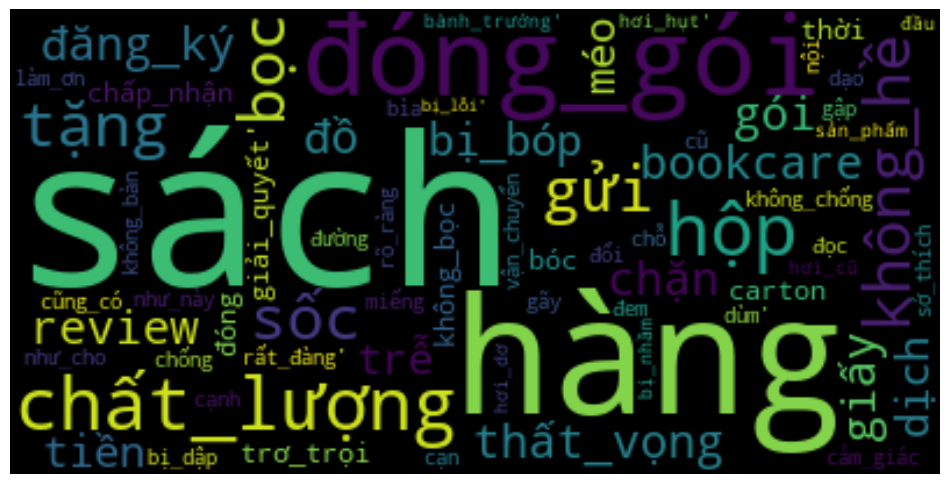

In [50]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral

In [51]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
wc_neutral.generate(str(df_final_neutral['processed_text'].values))

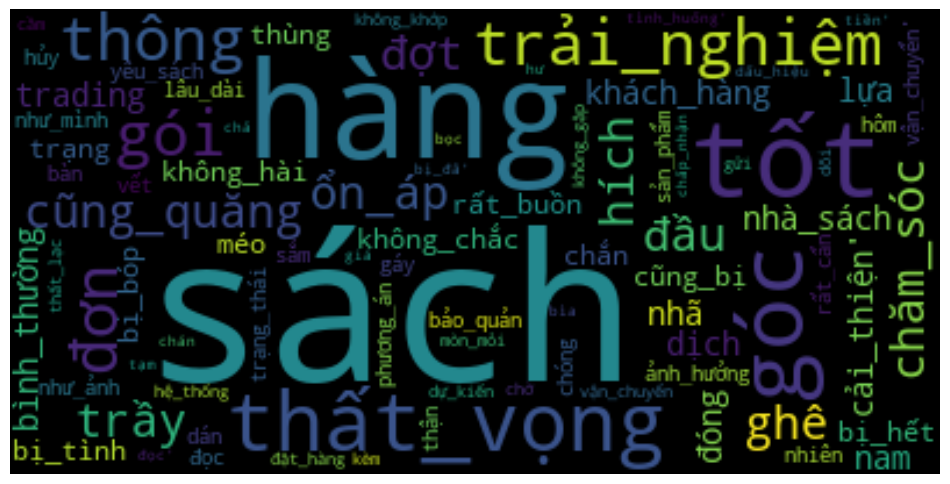

In [52]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

### Positive

In [53]:
df_final_like = df_final[df_final['class'] == 'positive' ]
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
wc_like.generate(str(df_final_like['processed_text'].values))

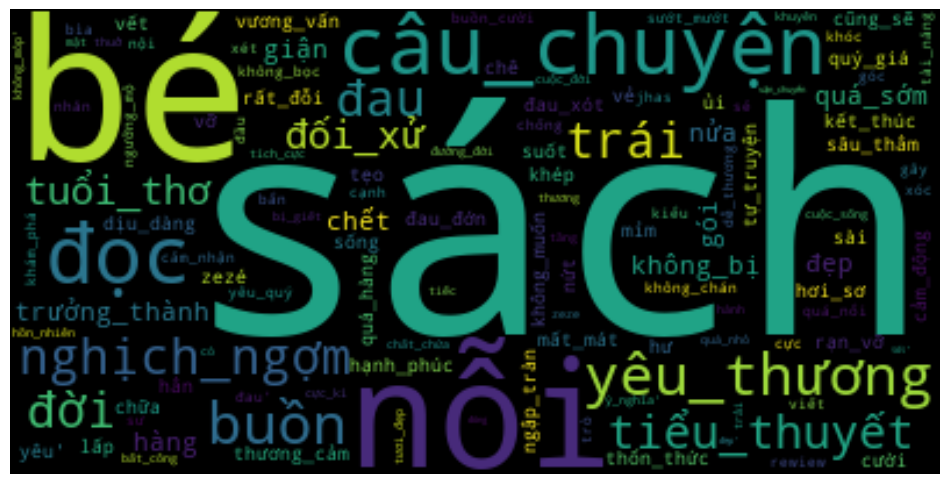

In [54]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()

Sau khi thực hiện quá trình tiền xử lí, nhận thấy bộ dữ liệu còn nhiều nội dung chưa chuẩn như hình thái chưa đúng với bình luận, chúng em đã xử lí bằng cách gán nhãn bằng tay cho hơn 40.000 câu.